In [31]:
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
import pandas as pd
import glob
import h5py
import re
from scipy.ndimage import gaussian_filter
from tqdm import tqdm
import scipy.io as sio
from matplotlib import pyplot as plt
from joblib import Parallel, delayed
import pickle
import os


monkey_names = ["W", "V"]
# aligned_events = ["StimOnset", "Choice", "RewFeedback"]
aligned_events = ["StimOnset"]

root_dir = '/Users/f005d7d/Documents/Attn_MdPRL/what-where-task/'
# root_dir = '/dartfs-hpc/scratch/f005d7d/what_where_analysis/'

bhv_path = os.path.join(root_dir, 'Behavior/')
processed_path = os.path.join(root_dir, 'processed/')
neural_path = os.path.join(root_dir, 'RasterVec_binSize_10ms/')

all_sess_regression_info = {
    'aligned_event': [],
    'monkey_name': [],
    'area_name': [],
    'sess_date': [],
    'betas': [],
    'exp_vars': [],
    'pvals': []
}

# 12 regressors, separate by blocks
regressor_names = ['type', 'block',
                    'S_curr', 'C_what_curr', 'C_where_curr', 'R_curr',
                    'C_what_prev', 'C_where_prev', 'R_prev',
                    'RXC_where', 'RXC_what',
                    'SXC_what', 'RXS', 'RXSXC_what']

regressor_expr = ['C(block_type, Sum)/C(block_id, Sum)',
                       '(C(block_type, Sum)/C(block_id, Sum))*(C_what_curr:C_where_curr)',
                       '(C(block_type, Sum)/C(block_id, Sum))*C_what_curr',
                       'C(block_type, Sum)*C_where_curr', 'C(block_type, Sum)*R_curr',
                       '(C(block_type, Sum)/C(block_id, Sum))*C_what_prev',
                       'C(block_type, Sum)*C_where_prev', 'C(block_type, Sum)*R_prev',
                       'C(block_type, Sum)*(R_prev:C_where_prev)',
                       '(C(block_type, Sum)/C(block_id, Sum))*(R_prev:C_what_prev)',
                       'C(block_type, Sum)*(C_what_curr:C_where_curr:C_what_prev)',
                       '(C(block_type, Sum)/C(block_id, Sum))*(R_prev:C_what_curr:C_where_curr)',
                       'C(block_type, Sum)*(R_prev:C_what_curr:C_where_curr:C_what_prev)']

var_names_in_table = ['C_what_curr', 'C_where_curr', 'R_curr', 'block_type', 'block_id',
                        'C_what_prev', 'C_where_prev', 'R_prev']

formula = 'fr~'+'+'.join(regressor_expr)

In [34]:
for event_idx, aligned_event in enumerate(aligned_events):
    for monkey_idx, monkey_name in enumerate(monkey_names):
        files = glob.glob(
            f'{neural_path}/{aligned_event}/RastVect-{monkey_name}*-binsize10ms-align2{aligned_event}.mat')
        for sess_idx in range(len(files)):
            filename = files[sess_idx]

            curr_sess_neural = h5py.File(filename)
            sess_date = re.search(re.compile(
                f'RastVect-{monkey_name}(\\d*)-binsize10ms-align2{aligned_event}.mat'), filename).groups()[0]

            neural_data = gaussian_filter(curr_sess_neural['aligned2event'], gauss_SD, mode='constant', axes=2)

            bhv_filename = bhv_path+'SPKcounts_'+monkey_name+sess_date+'cue_MW_250X250ms.mat'
            curr_sess_bhv = sio.loadmat(
                bhv_path+'SPKcounts_'+monkey_name+sess_date+'cue_MW_250X250ms.mat')
            task_info = curr_sess_bhv['Y']

            # only keep chosen image, chosen loc, reward, block type, block id
            task_info = task_info[:, [0, 1, 2, 9, 7]].astype(float)

            trial_mask = task_info[:, 4] <= 24
            task_info = task_info[trial_mask]
            neural_data = neural_data[trial_mask]
            area_idx = curr_sess_neural['vectorInfo']['Array'][:].squeeze()
            # neural_data = neural_data[:,:,window_start:]

            neuron_mask = np.nonzero(np.min(neural_data.sum(0), 1))[0]
            neural_data = neural_data[:, neuron_mask, :]
            area_idx = area_idx[neuron_mask].squeeze()

            num_trials, num_units, num_timesteps = neural_data.shape

            print("--------------------------------------------------------------------")
            print("aligned to: " + aligned_event + ", monkey: " +
                    monkey_name + ", session: " + sess_date + ", #trials=" + str(num_trials))

            task_info[:, :3] = task_info[:, :3]*2-1
            task_info[:, 3] = task_info[:, 3]*2-3
            task_info[:, 4] = task_info[:, 4] % 12

            # make the time-lagged part of the design
            task_info_prev = np.concatenate([np.array([[0, 0, 0]]), task_info[:-1, :3]], axis=0)

            # put together design matrix
            # C_what_curr, C_where_curr, R_curr, block_id, block_type
            # C_what_prev, C_where_prev, R_curr
            X = np.concatenate([task_info, task_info_prev], axis=1)

            num_betas = 158
            num_exp_vars = 32

            all_units_beta = np.ones((num_timesteps, num_units, num_betas))*np.nan
            all_units_exp_var = np.ones((num_timesteps, num_units, num_exp_vars))*np.nan
            all_units_pvals = np.ones((num_timesteps, num_units, num_exp_vars))*np.nan

            for unit_idx in tqdm(range(num_units)):
                def run_linreg_anova(time_idx):
                    curr_unit_time_fr = neural_data[:, unit_idx, time_idx]
                    tbl = pd.DataFrame(np.concatenate([curr_unit_time_fr[:, None], X], axis=1),
                                        columns=['fr']+var_names_in_table)
                    
                    # fit linear model
                    mdl = smf.ols(formula, tbl).fit()
                    
                    # calculate anova
                    anova_mdl = sm.stats.anova_lm(mdl, typ=3)

                    # calculate effect size for anova
                    ms_error = anova_mdl.loc[:,'sum_sq'].iloc[-1]/anova_mdl.loc[:,'sum_sq'].iloc[-1]
                    omega_sq = (anova_mdl.loc[:,'sum_sq'].iloc[:-1]-anova_mdl.loc[:,'sum_sq'].iloc[:-1]*ms_error)/ \
                                    (anova_mdl.loc[:,'sum_sq'].sum()+ms_error)

                    pvals = anova_mdl.loc[:,'PR(>F)'].iloc[:-1].to_numpy().squeeze()
                    print(anova_mdl)

                    return [mdl.params, omega_sq, pvals]

                linreg_anova_results = Parallel(n_jobs=1)(
                    delayed(run_linreg_anova)(time_idx) for time_idx in range(num_timesteps))

                all_units_beta[:, unit_idx, :] = np.stack([curr_time_results[0] for curr_time_results in linreg_anova_results])
                all_units_exp_var[:, unit_idx, :] = np.stack([curr_time_results[1] for curr_time_results in linreg_anova_results])
                all_units_pvals[:, unit_idx, :] = np.stack([curr_time_results[2] for curr_time_results in linreg_anova_results])

            all_sess_regression_info['monkey_name'].append(monkey_name)
            all_sess_regression_info['aligned_event'].append(aligned_event)
            all_sess_regression_info['area_name'].append(area_idx)
            all_sess_regression_info['sess_date'].append(sess_date)
            all_sess_regression_info['betas'].append(all_units_beta)
            all_sess_regression_info['exp_vars'].append(all_units_exp_var)
            all_sess_regression_info['pvals'].append(all_units_pvals)

            with open(os.path.join(processed_path, 'all_sess_regression_info.pkl'), 'wb') as f:
                pickle.dump(all_sess_regression_info, f)

--------------------------------------------------------------------
aligned to: StimOnset, monkey: W, session: 20160122, #trials=1923


  0%|          | 0/579 [00:00<?, ?it/s]

                                                          sum_sq      df  \
Intercept                                           5.072125e-03     1.0   
C(block_type, Sum)                                  4.205781e-04     1.0   
C(block_type, Sum):C(block_id, Sum)                 2.199228e-03    22.0   
C_what_curr:C_where_curr                            2.723506e-04     1.0   
C(block_type, Sum):C_what_curr:C_where_curr         1.048399e-05     1.0   
C(block_type, Sum):C(block_id, Sum):C_what_curr...  2.160338e-03    22.0   
C_what_curr                                         1.915140e-04     1.0   
C(block_type, Sum):C_what_curr                      3.457309e-07     1.0   
C(block_type, Sum):C(block_id, Sum):C_what_curr     2.132503e-03    22.0   
C_where_curr                                        3.240731e-06     1.0   
C(block_type, Sum):C_where_curr                     1.373784e-04     1.0   
R_curr                                              4.374106e-06     1.0   
C(block_type

  0%|          | 0/579 [00:02<?, ?it/s]


KeyboardInterrupt: 

(-0.001, 0.05)

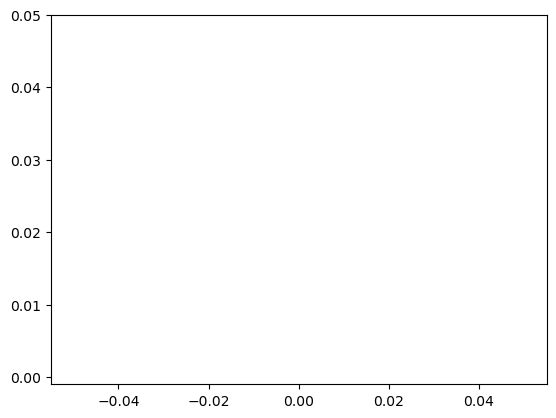

In [25]:
plt.plot(all_units_exp_var[:,1,13])
plt.ylim([-0.001, 0.05])